In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from sklearn.datasets import load_wine

# Data Prep

In [89]:
dat = load_wine()
X_temp = pd.DataFrame(dat['data'], columns=dat['feature_names'])
y_temp = pd.Series(dat['target'])
y_temp = y_temp.rename('target')
X_temp.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [90]:
full_dat = pd.concat([X_temp,y_temp], axis=1)
full_dat = full_dat[full_dat['target'].isin([0,1])]
full_dat.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [91]:
full_dat.shape

(130, 14)

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [93]:
X = full_dat.drop(columns='target')
y = full_dat['target']

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
standardize = StandardScaler()
X_train = standardize.fit_transform(X_train)
X_test = standardize.transform(X_test)
y_train = np.array(y_train).reshape(-1,1)
y_test = np.array(y_test).reshape(-1,1)


# Base Logistic Regression

In [95]:
from sklearn.linear_model import LogisticRegression

In [96]:
clf = LogisticRegression(C=1e5, max_iter=100_000, verbose=5, n_jobs=-1)
clf.fit(X_train, y_train)

/opt/conda/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


LogisticRegression(C=100000.0, max_iter=100000, n_jobs=-1, verbose=5)

In [97]:
clf.coef_

array([[-4.7982218 , -1.65370396, -3.84697205,  5.24396544, -0.50953001,
         1.50483763, -1.16904972,  0.60263561,  0.15841013, -1.47868402,
         0.70543493, -3.28897935, -7.09110805]])

In [98]:
w_best = clf.coef_.reshape(-1,1)
z = -y_train * (X_train @ w_best)
best_loss = np.sum(np.log(1 + np.exp(z)))
best_loss

31.894040426617714

# Maximum Gradient Coordinate Descent

$$
\nabla{f(w)} = \sum_{i=1}^n \frac{-y^{(i)}x^{(i)}}{1+\exp(y^{(i)}w^T x^{(i)})}
$$

In [99]:
w_0 = np.zeros(X_train.shape[1])
w_0 = np.array(w_0).reshape(-1, 1)

In [100]:
def grad_logistic(w, X, y):
    z = y * (X @ w)
    z = np.clip(z, -100000, 100000)
    exp_term = np.exp(z)
    grad = np.sum((-y * X) / (1 + exp_term), axis=0)
    return grad

grad_logistic(w_0, X_train, y_train)



array([ 20.88678612,   0.13063692,   8.27721288, -12.65425015,
        11.51454032,  13.38346666,  15.84164915,  -9.08597012,
         8.27757156,  18.93856729,   2.81122556,  11.1203019 ,
        22.35311923])

In [101]:
def grad_descent(X, y, w, eta= 0.01, epochs = 10000):
    losses = []
    w = w.copy()

    for _ in range(epochs):
        grad = grad_logistic(w, X, y)
        j = np.argmax(np.abs(grad))
        w[j] -= eta * grad[j]

        z = -y * (X @ w)
        z = np.clip(z, -100000, 100000)

        loss = np.sum(np.log(1 + np.exp(z)))
        losses.append(loss)

        if loss < best_loss:
            break
    return w, losses

In [102]:
epochs = 1_000_000
w, losses = grad_descent(X_train, y_train, w_0, epochs=epochs)

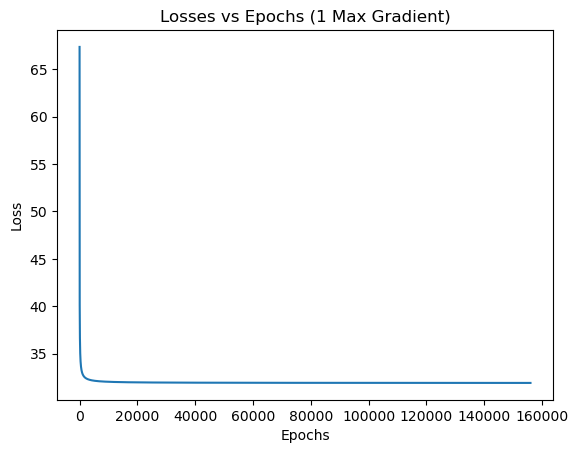

In [103]:
plt.plot(np.arange(0, len(losses)), losses)
plt.title('Losses vs Epochs (1 Max Gradient)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [104]:
len(losses)

156026

In [105]:
best_grad, max_desc_grad = (
    np.linalg.norm(grad_logistic(w_best, X_train, y_train)),
    np.linalg.norm(grad_logistic(w, X_train, y_train))
)
best_grad, max_desc_grad

(0.012867068737195805, 0.007778688912149258)

In [106]:
best_loss, np.min(losses)

(31.894040426617714, 31.894040396621286)

# Random Gradient Coordinate Descent

In [107]:
def random_grad_descent(X, y, w, eta= 0.01, epochs = 10000):
    losses = []
    w = w.copy()

    for _ in range(epochs):
        grad = grad_logistic(w, X, y)
        j = np.random.choice(w.shape[0], 1, replace = True)
        w[j] -= eta * grad[j]

        z = -y * (X @ w)
        z = np.clip(z, -100000, 100000)

        loss = np.sum(np.log(1 + np.exp(z)))
        losses.append(loss)

        if loss < best_loss:
            break
    return w, losses

In [108]:
w_random, losses_random = random_grad_descent(X_train, y_train, w_0, epochs=epochs)

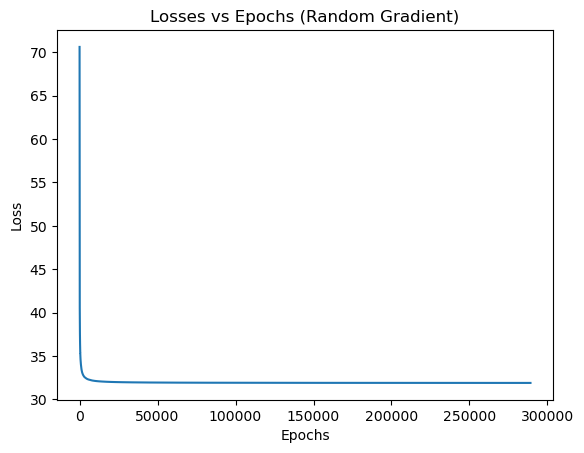

In [109]:
plt.plot(np.arange(0, len(losses_random)), losses_random)
plt.title('Losses vs Epochs (Random Gradient)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [110]:
len(losses_random)

289130

In [111]:
best_grad, random_desc_grad = (
    np.linalg.norm(grad_logistic(w_best, X_train, y_train)),
    np.linalg.norm(grad_logistic(w_random, X_train, y_train))
)
best_grad, random_desc_grad

(0.012867068737195805, 0.006406963364964312)

# Lipschitz Rule

$$
\nabla ^2 f(w) = \sum_{i=1} ^ n \frac{y^{(i)2} x^{(i)} x ^{(i)T} \exp(-y^{(i)}w^Tx^{(i)})}{(1 + \exp(-y^{(i)}w^Tx^{(i)}))^2}
$$

In [112]:
def find_hessian(X, y, w):
    n, d = X.shape
    H = np.zeros((d, d))
    for i in range(n):
        x_i = X[i].reshape(-1,1)
        y_i = y[i]
        exp_term = np.exp(-y_i * w.T @ X[i])
        coef = (y_i ** 2 * exp_term) / (1 + exp_term)**2
        H += coef * (x_i @ x_i.T)
    return H

In [113]:
def grad_descent_lipschitz(X, y, w, epochs = 10000):
    losses = []
    w = w.copy()

    for _ in range(epochs):
        grad = grad_logistic(w, X, y)
        j = np.argmax(np.abs(grad))
        w[j] -= (1/find_hessian(X, y, w)[j, j]) * grad[j]

        z = -y * (X @ w)
        z = np.clip(z, -100000, 100000)

        loss = np.sum(np.log(1 + np.exp(z)))
        losses.append(loss)

        if loss < best_loss:
            break
    return w, losses

In [114]:
epochs = 1_000_000
w, gsl_losses = grad_descent_lipschitz(X_train, y_train, w_0, epochs=epochs)

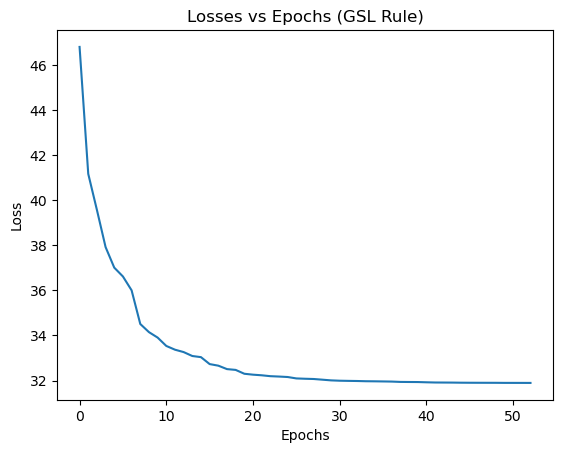

In [115]:
plt.plot(np.arange(0, len(gsl_losses)), gsl_losses)
plt.title('Losses vs Epochs (GSL Rule)')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

In [123]:
len(gsl_losses)

53

# Collective Graphs

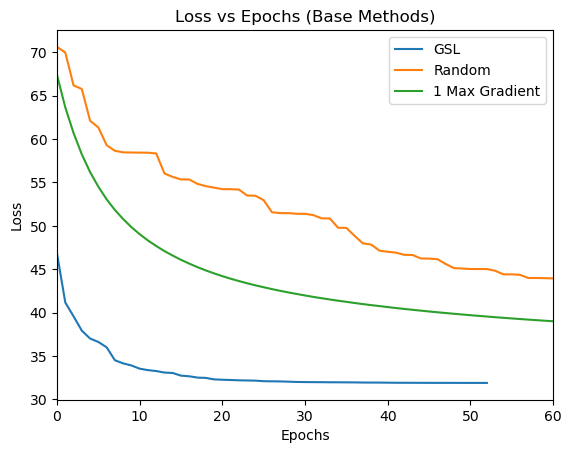

In [122]:
plt.plot(np.arange(0, len(gsl_losses)), gsl_losses, label='GSL')
plt.plot(np.arange(0, len(losses_random)), losses_random, label='Random')
plt.plot(np.arange(0, len(losses)), losses, label='1 Max Gradient')
plt.xlim((0,60))
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Loss vs Epochs (Base Methods)')
plt.legend()
plt.show()
